<center><img src="./images/rtu_logo_lv.png" alt="RTU" title="RTU" width="150em"/></center>

<center><b>RĪGAS TEHNISKĀ UNIVERSITĀTE</b></center>
<center><b>DATORZINĀTNES UN INFORMĀCIJAS TEHNOLOĢIJAS FAKULTĀTE</b></center>
<center><b>Priekšmeta "Ievads mākslīgos neironu tīklos"</b></center><center>

<center><b>3. mājasdarbs</b></center>

<div style="text-align: right">
    LDsI 12300 Lietišķo datorsistēmu institūts<br>
    RDBD0 Datorsistēmas<br>
    <b>3. kursa 3. grupas</b> pilna laika klātienes <b>students</b><br>
    Oļegs Korsaks<br>
    <b>Studenta apliecības Nr.: </b>051RDB146<br>
</div>
<center><b>Rīga, 2021</b></center>
<div style="display:none">\pagebreak</div>

***

## Risināma uzdevuma nostādne <a class="anchor" id="chapter1"></a>

1. Izvēlēties uzdevumu un sagatavot datu kopu ar vismaz 20 ierakstiem, kuriem jābūt aprakstītiem ar vismaz diviem skaitliskiem atribūtiem.
2. Izveidot viendimensiālo (vai 2D) SOM tīklu ar vismaz trim neironiem. Izmantojiet apmācības koeficientu ŋ=0.1.
3. Apmācīt neironu tīklu, izmantojot izvēlētā varianta datus.
4. Augstākam novērtējumam: realizēt SOM tīkla apmācību, kas paredz topoloģiskās apkaimes Sw(t) un attiecīgās enerģijas aprēķināšanu blakus neironu svaru koriģēšanai.
5. „Paspēlēties” ar SOM, mainot apmācības koeficientu (piem. ŋ=0.3;0.5;0.7;0.9).
6. Atskaitē atbildēt uz jautājumiem:
    * Kurā brīdī (iterācijas numurs) tīklu var uzskatīt par apmācītu?
    * Kā apmācības koeficients ietekmē kļūdas konverģenci?
    * Paskaidrojiet, kā var koriģēt apmācības koeficientu, lai ātrāk apmācītu tīklu?
    * Parādiet, kā dati tika klasterizēti (vismaz aprakstiet, no kādiem elementiem sastāv klasteri).
7. Rezultātus noformēt atskaites formā.

Izvēlējos: Variants II. Medicīniskai iestādei ir nepieciešams klasterizēt pacientus trijās grupās pēc viņu svara
un auguma.

In [1]:
%matplotlib inline

In [2]:
import math

from random import random

import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context('notebook', font_scale=2.0)
sns.set_style('darkgrid')

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from IPython.display import HTML

### Dati

In [3]:
# Patient: Weight, Height

data = {
    'VU1': (77, 170),
    'VU2': (1452, 110),
    'VU3': (20345, 178),
    'VU4': (1024, 150),
    'VU5': (7341, 153),
    'VU6': (4205, 121),
    'VU7': (1452, 181),
    'VU8': (20345, 130),
    'VU9': (1024, 165),
    'VU10': (7341, 161),
    'VU11': (61, 148),
    'VU12': (59, 141),
    'VU13': (40, 118),
    'VU14': (61, 133),
    'VU15': (81, 120),
    'VU16': (94, 171),
    'VU17': (110, 200),
    'VU18': (94, 160),
    'VU19': (444, 182),
    'VU20': (333, 191),
    'VU21': (834, 171),
    'VU22': (43, 145),
    'VU23': (10, 30),
    'VU24': (20, 50),
    'VU25': (5, 28),
}

Paskatīsimies uz datu sadalījumu

Dažiem te ir vajadzīga nopietna dieta.

In [4]:
neuron_colors = ('red', 'yellow', 'green')


def show_plot(plt, samples, neurons: tuple[list[float]], neuron_colors):
    x = [item[0] for item in samples]
    y = [item[1] for item in samples]
    plt.scatter(x, y, linewidth=1, edgecolors='black')

    plt.plot([neurons[0][0], neurons[1][0]],[neurons[0][1], neurons[1][1]], c='black')
    plt.plot([neurons[1][0], neurons[2][0]],[neurons[1][1], neurons[2][1]], c='black')
    plt.plot([neurons[2][0], neurons[0][0]],[neurons[2][1], neurons[0][1]], c='black')

    for neuron, color in zip(neurons, neuron_colors):
        plt.scatter(neuron[0], neuron[1], c=color, linewidth=1, edgecolors='black')

    plt.show()
    
    
def show_history_plot(plt, samples, history: list[tuple[list[float]]], neuron_colors):
    x = [item[0] for item in samples]
    y = [item[1] for item in samples]
    
    fig, ax = plt.subplots()
    line, = ax.plot([])
    
    def animate(frame_num: int):
        ax.clear()
        neurons = history[frame_num]
        ax.scatter(x, y, linewidth=1, edgecolors='black')

        line.plot([neurons[0][0], neurons[1][0]],[neurons[0][1], neurons[1][1]], c='black')
        line.plot([neurons[1][0], neurons[2][0]],[neurons[1][1], neurons[2][1]], c='black')
        line.plot([neurons[2][0], neurons[0][0]],[neurons[2][1], neurons[0][1]], c='black')

        for neuron, color in zip(neurons, neuron_colors):
            ax.scatter(neuron[0], neuron[1], c=color, linewidth=1, edgecolors='black')
        
        ax.show()
    
    anim = FuncAnimation(fig, animate, frames=len(history), interval=20)
    plt.show()
    
    return anim

In [5]:
def fit(neurons: tuple[list[float]], samples: tuple[list[float]], epochs: int, learning_rate: float):
    history = []
    
    for epoch in range(epochs):
        for sample in samples:
            bmu_distance = float('inf')
            bmu_idx = 0
            bmu_weight_vector = None

            for idx, weight_vector in enumerate(neurons):
                distance = math.sqrt((sample[0] - weight_vector[0]) ** 2 + (sample[1] - weight_vector[1]) ** 2)

                if distance < bmu_distance:
                    bmu_distance = distance
                    bmu_idx = idx
                    bmu_weight_vector = weight_vector

            bmu_weight_vector[0] = bmu_weight_vector[0] + learning_rate * (sample[0] - bmu_weight_vector[0])
            bmu_weight_vector[1] = bmu_weight_vector[1] + learning_rate * (sample[1] - bmu_weight_vector[1])

            for idx, weight_vector in enumerate(neurons):
                if idx == bmu_idx:
                    nt = learning_rate
                else:
                    nt = learning_rate * 0.125
                    
                weight_vector[0] = weight_vector[0] + nt * (sample[0] - weight_vector[0])
                weight_vector[1] = weight_vector[1] + nt * (sample[1] - weight_vector[1])
        
        history.append(tuple(neuron.copy() for neuron in neurons))
    
    return history

Initial state:


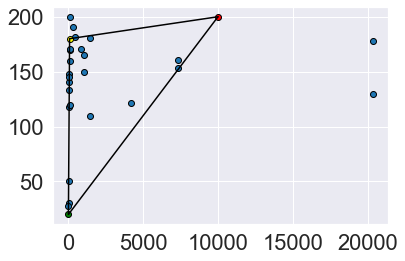

learning_rate=0.1; epochs=1


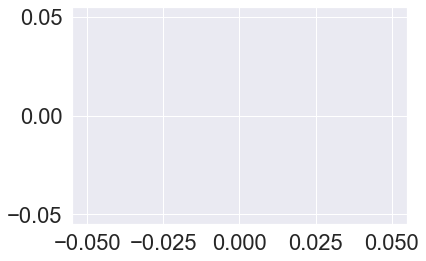

Initial state:


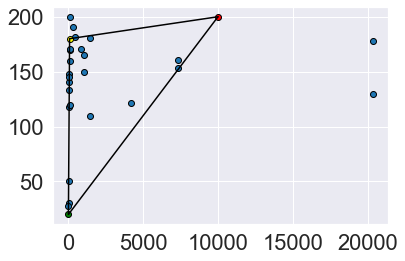

learning_rate=0.1; epochs=10


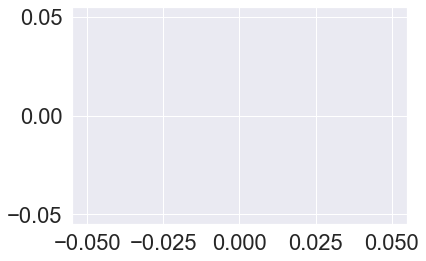

Initial state:


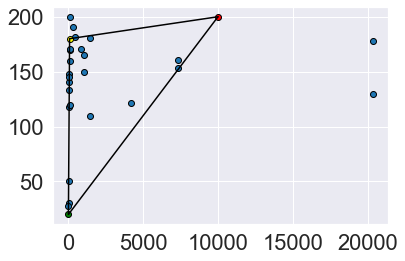

learning_rate=0.1; epochs=100


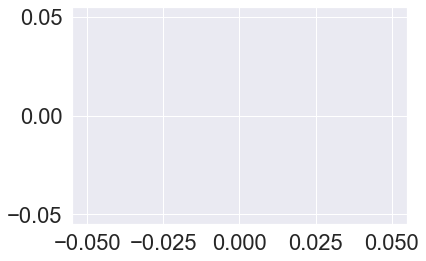

Initial state:


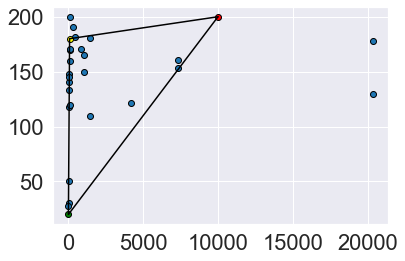

learning_rate=0.3; epochs=1


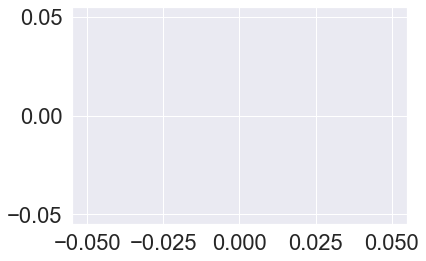

Initial state:


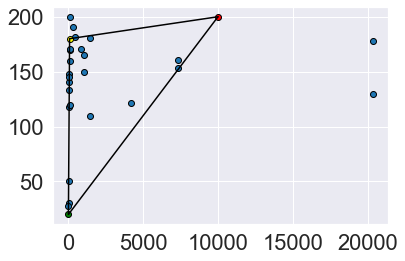

learning_rate=0.3; epochs=10


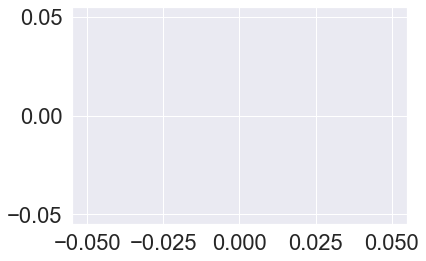

Initial state:


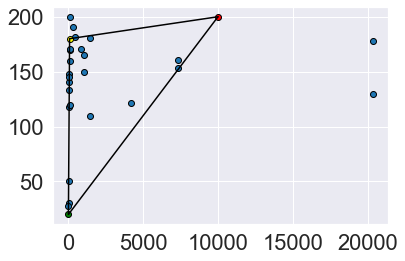

learning_rate=0.3; epochs=100


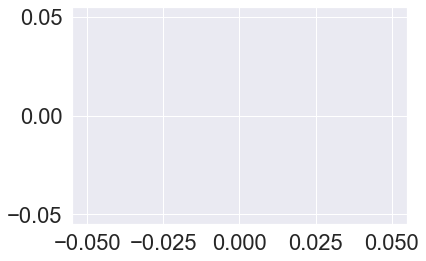

Initial state:


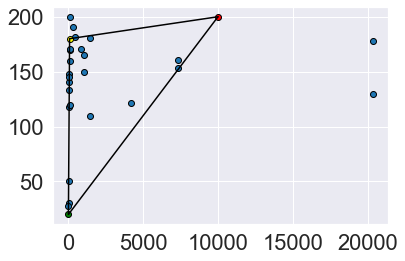

learning_rate=0.5; epochs=1


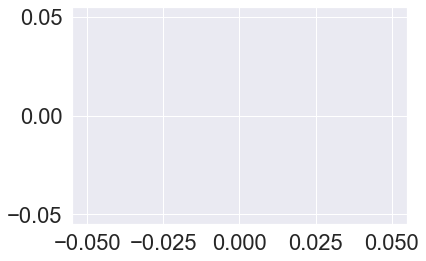

Initial state:


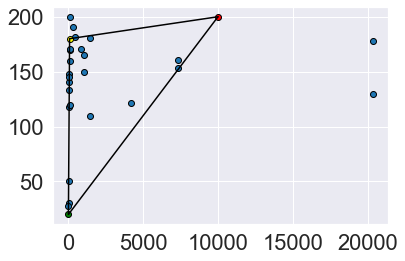

learning_rate=0.5; epochs=10


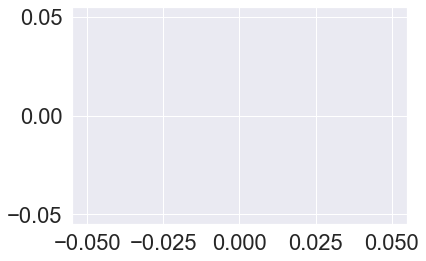

Initial state:


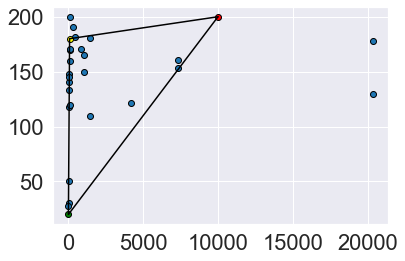

learning_rate=0.5; epochs=100


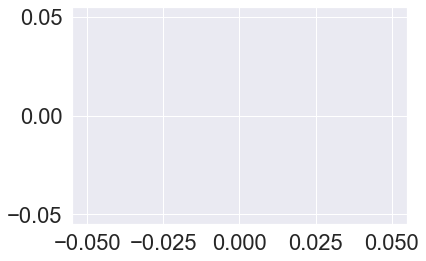

Initial state:


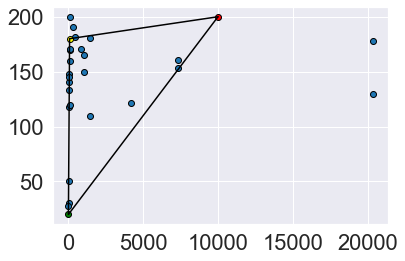

learning_rate=0.7; epochs=1


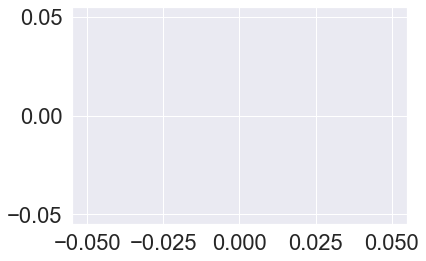

Initial state:


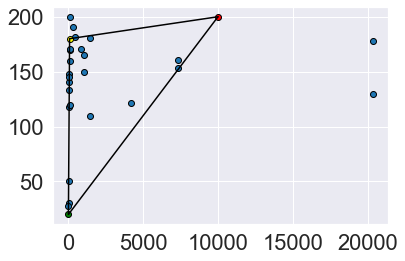

learning_rate=0.7; epochs=10


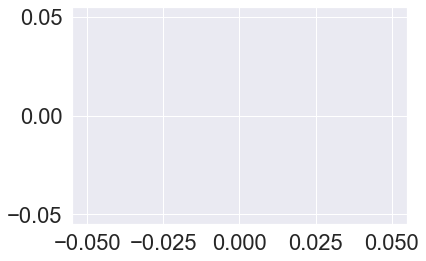

Initial state:


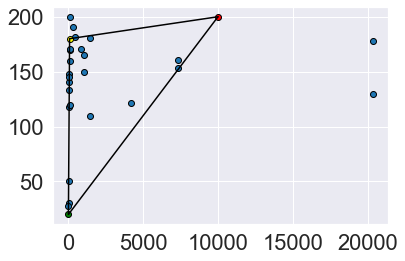

learning_rate=0.7; epochs=100


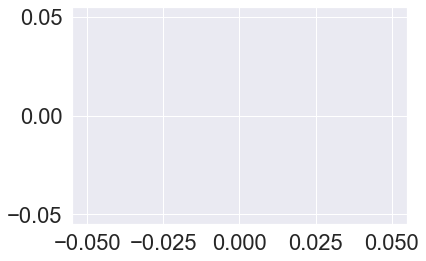

Initial state:


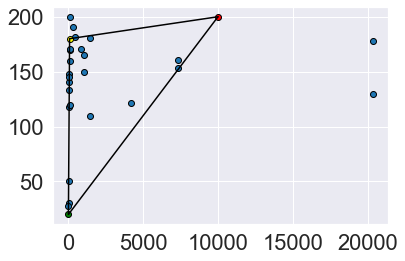

learning_rate=0.9; epochs=1


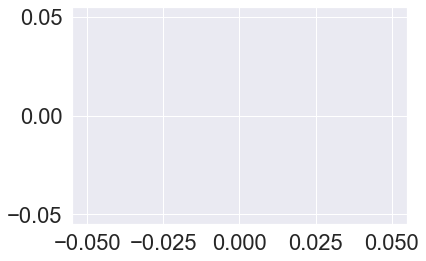

Initial state:


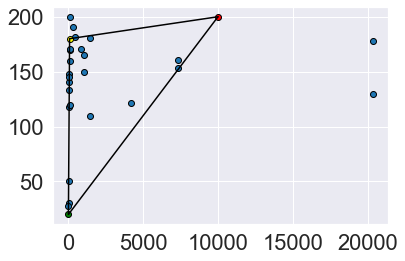

learning_rate=0.9; epochs=10


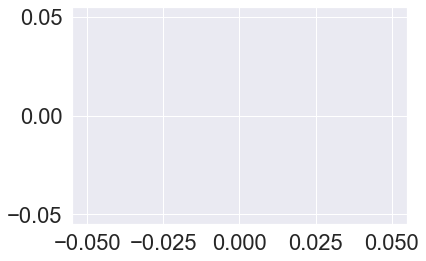

Initial state:


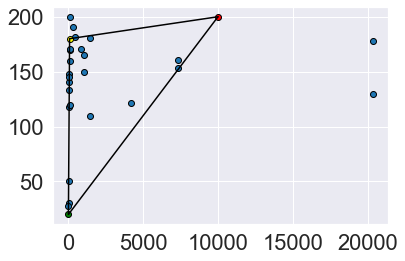

learning_rate=0.9; epochs=100


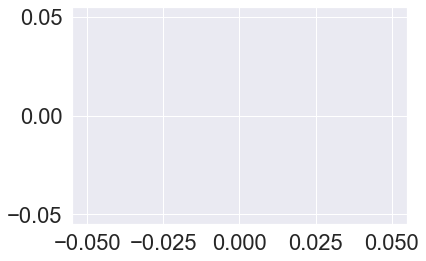

In [6]:
animations = []

for learning_rate in (0.1, 0.3, 0.5, 0.7, 0.9):
    for epochs in (1, 10, 100):
        neurons = ( # input nodes
            [10000, 200], # huge people
            [80, 180], # normal people
            [3, 20], # children
        )
        samples = tuple(data.values())
        print('Initial state:')
        show_plot(plt, samples, neurons, neuron_colors)
        print(f'{learning_rate=}; {epochs=}')
        history = fit(neurons, samples, epochs=epochs, learning_rate=learning_rate)
        animations.append(show_history_plot(plt, samples, history, neuron_colors))

## Secinājumi

TBD